# Getting Started with the TrebleSDK

The TrebleSDK provides a library of examples of how to interact with the Terra15 Treble Distributed Acoustic Sensor (DAS). These examples include how to post-process data saved in the Treble .hdf5 format, and how to acquire and process data in real-time directly from the Treble Server using the python API.

This notebook and script examples are not exhaustive! Contributions to the SDK are welcome, as are requests for examples or features.

Please send any questions you have about the SDK to simon.stobie@terra15.com, or submit a pull request at https://github.com/terra15collab/TrebleSDK.

# Processing Treble Data

## Loading Data
Treble systems save data as .hdf5 files using the open source [HDF5](https://www.hdfgroup.org/solutions/hdf5/) data format. 
HDF5 files are cross-platform compatible and accessible using C, Java, Matlab and various other programming languages, however for simplicity they are processed here in Python using the [h5py](https://docs.h5py.org/en/stable/) library.

A typical Treble .hdf5 file is structured as follows, consisting of the main 2D array of acoustic data, one or more timing arrays, and several sets of diagnostic data.

```
/sample_data/example_triggered_shot.hdf5
    - data_product
        - data
        - gps_time
        - posix_time
    - diagnostics
        - OTDR
        - SNR
```

Each dataset can be indexed into using POSIX-like paths, eg: `f["data_product/data"]`. 
HDF5 files allow loading data in small slices without loading the entire - sometimes prohibitively large - dataset into memory.
Files are also self-describing, with metadata stored as attributes for each dataset.



In [1]:
import h5py
import numpy as np

filepath = "sample_data/example_triggered_shot.hdf5"

# time and space indices for slicing
t_start = 0 # (s)
t_stop = 1.5 # (s)

x1 = 5 # channel 
x2 = 200 # channel

with h5py.File(filepath, "r") as f:
    # accesses data
    md = dict(f.attrs)

    data = f["data_product/data"]
    t = f["data_product/gps_time"]
    x = md['sensing_range_start'] + np.arange(0, md['nx']) * md["dx"]
        
    # calculates time slice indices
    t1 = int(round(t_start/md['dt_computer']))
    t2 = int(round(t_stop/md['dt_computer']))
    
    # loads slice of data into memory
    data = data[t1:t2, x1:x2]
    t = t[t1:t2]
    x = x[x1:x2]
    
print(
    f"{md['data_product']} data:\n",
    f"(nt, nx) = {data.shape}\n",
    f"t: {t[-1]-t[0]:.4f}s, {t[0]:.2f} -> {t[-1]:.2f}\n",
    f"x: {x[-1]-x[0]:.1f}m, {x[0]:.1f}m -> {x[-1]:.1f}m\n\n",
    "Metadata:"
)

md

velocity data:
 (nt, nx) = (1500, 195)
 t: 1.4990s, 1674798843.64 -> 1674798845.14
 x: 316.9m, 418.2m -> 735.1m

 Metadata:


{'acoustic_bandwidth_end': 500.0,
 'acoustic_bandwidth_start': 0.01,
 'amplifier_incoming_current': 110.0,
 'amplifier_outgoing_current': 110.0,
 'amplifier_warning_status': 'healthy',
 'amplifiers_disarmed': False,
 'amplifiers_enabled': True,
 'client_fn_applied': '',
 'clock_source': 'internal',
 'coding': 'None',
 'cpu_percent': 28.2,
 'cpu_temperature': array([], dtype=float64),
 'data_product': 'velocity',
 'data_product_units': 'm/s',
 'digitizer_firmware_version': '1795',
 'digitizer_temperature': 55.875,
 'dt_computer': 0.001,
 'dx': 1.6335238141942516,
 'fibre_health_status': 'healthy',
 'file_start_computer_time': 1674798843.7017803,
 'file_start_computer_time_string': '2023-01-27T05:54:03.701780Z',
 'file_start_gps_time': 1674798843.6369076,
 'file_version': 6,
 'frame_size': 160,
 'gauge_length': 1.6335238141942516,
 'gps_2d_uncertainty': 3.0341924790625923,
 'gps_datum': 'WGS84',
 'gps_geohash': 'qd66mh6sy930',
 'gps_latitude': -31.924074,
 'gps_locked': True,
 'gps_longi

## Converting to Strain Rate
Treble data is most commonly saved in units of velocity (m/s) or strain rate (strain/s). \
Velocity data can be converted to strain rate by applying a gauge calculation - this allows variable gauge length processing, a unique advantage of data acquired using the Treble.\
By default, the gauge length should be equal to the pulse length used during the recording.

strainrate data (1.63m gauge)
 (nt, nx) = (1500, 194)
 t: 1.4990s, 1674798843.64 -> 1674798845.14
 x: 315.3m, 419.0m -> 734.3m


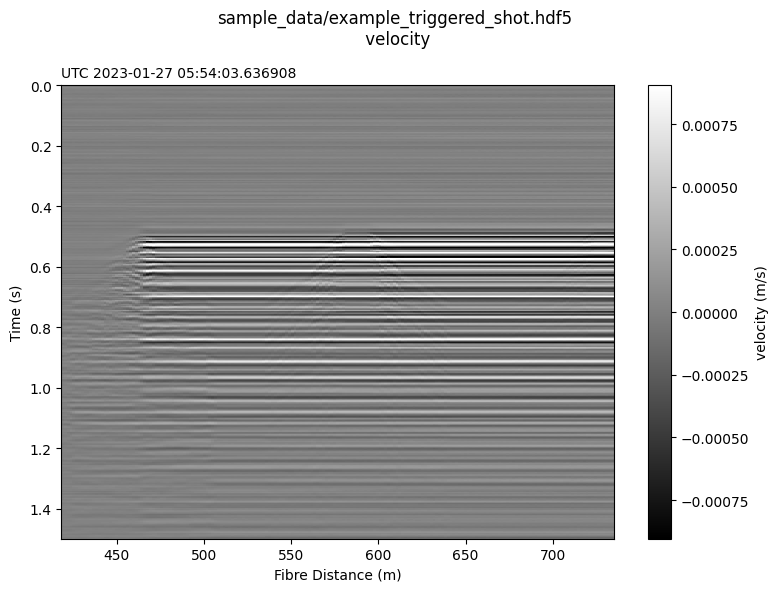

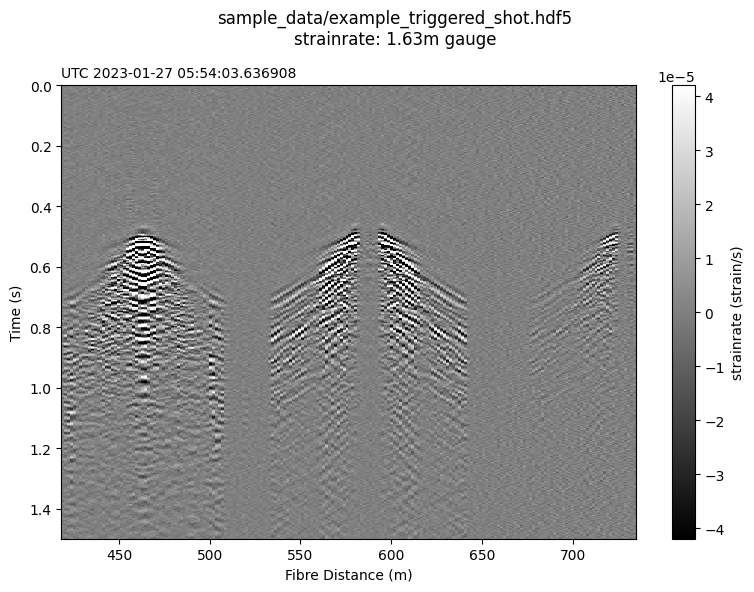

In [2]:
import matplotlib.pyplot as plt
from datetime import datetime

def plot_data(data, t, x, title=None, units=None):
    t_start = datetime.utcfromtimestamp(t[0])
    t_rel = t - t[0]

    plt.figure(figsize=(8, 6))

    if title is not None:
        plt.suptitle(title, fontsize=12)

    plt.title(f'UTC {t_start}', loc='left', fontsize=10)

    plt.imshow(
        data,
        aspect="auto",
        cmap="gray",
        extent=(x[0], x[-1], t_rel[-1], t_rel[0]),
        vmin=-4 * np.std(data),
        vmax=4 * np.std(data),
        interpolation="none"
    )

    cbar = plt.colorbar()
    if units is not None:
        cbar.set_label(units)

    plt.xlabel("Fibre Distance (m)")
    plt.ylabel("Time (s)")
    plt.tight_layout()

def convert_velocity_to_strainrate(data, gauge_length_m, dx):
    gauge_samples = int(round(gauge_length_m / dx))
    return (data[:, gauge_samples:] - data[:, :-gauge_samples]) / (gauge_samples * dx)

GAUGE = md["pulse_length"] # (m)

plot_data(data, t, x, f"{filepath}\n velocity", units="velocity (m/s)")

strain_rate = convert_velocity_to_strainrate(data, GAUGE, md['dx'])

# Gauge length is rounded to the nearest sample
n_gauge = int(round(GAUGE / md['dx']))
gauge_rounded = n_gauge * md['dx']
# The gauge calculation crops the data by 1 gauge length, so the x-array must also be cropped and shifted by GAUGE/2
x_gauge = x[:-n_gauge] + gauge_rounded/2

print(
    f"strainrate data ({gauge_rounded:.2f}m gauge)\n",
    f"(nt, nx) = {strain_rate.shape}\n",
    f"t: {t[-1]-t[0]:.4f}s, {t[0]:.2f} -> {t[-1]:.2f}\n",
    f"x: {x_gauge[-1]-x_gauge[0]:.1f}m, {x_gauge[0]:.1f}m -> {x_gauge[-1]:.1f}m"
)

plot_data(strain_rate, t, x, f"{filepath}\nstrainrate: {gauge_rounded:.2f}m gauge", units="strainrate (strain/s)")


## Timing Data
Two timing arrays are saved in each Treble data file. Both arrays are stored as Unix timestamps:
- `data_product/gps_time`: Accurate GPS-synchronised time array. This data will only be GPS-synchronised if a GPS antenna was connected to the Treble and locked during the acquisition.
- `data_product/posix_time`: NTP-synchronized computer time array. This array is less accurate than GPS time but should be used as a fallback if no GPS antenna was used.

Sample-spacing in time, dt, is recorded in metadata as `dt_computer`.

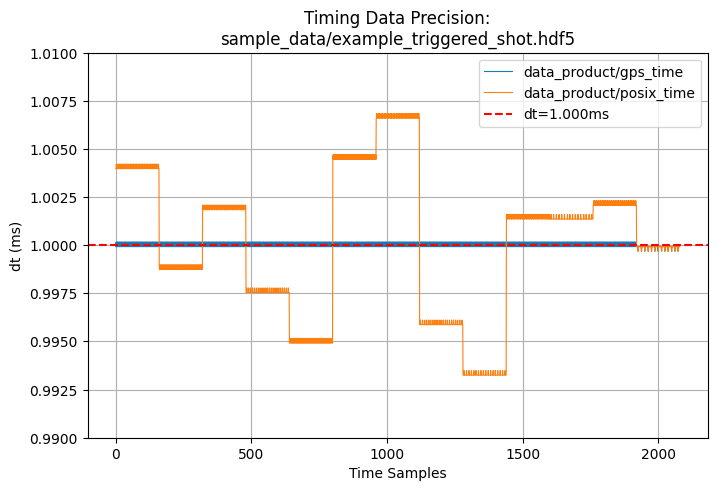

In [3]:
with h5py.File(filepath, "r") as f:
    md = dict(f.attrs)
    
    dt = md["dt_computer"]
    gps_time = f["data_product/gps_time"][:]
    posix_time = f["data_product/posix_time"][:]
    
plt.figure(figsize=(8, 5))
plt.title(f"Timing Data Precision:\n{filepath}")
plt.plot(np.diff(gps_time)*1e3, linewidth=0.8, label="data_product/gps_time")
plt.plot(np.diff(posix_time)*1e3, linewidth=0.8, label="data_product/posix_time")
plt.axhline(dt*1e3, c="r", linestyle="--", label=f"dt={dt*1e3:.3f}ms")
plt.xlabel("Time Samples")
plt.ylabel("dt (ms)")
plt.ylim(dt*0.99e3, dt*1.01e3)
plt.legend()
plt.grid()
plt.show()

## Triggering
For a triggered acquisition, each trigger event is stored as 2 values:
- `trigger_start_line`: The time sample of the trigger event within the data array, and 
- `trigger_start_time`: The Unix timestamp of the trigger event.

Either of these values can be used to accurately crop or align triggered data.

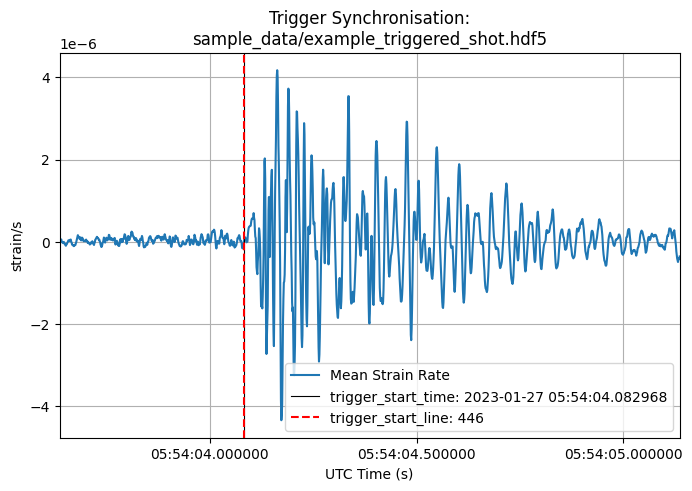

In [4]:
from matplotlib.dates import DateFormatter

trigger_start_line = md["trigger_start_line"]
trigger_start_time = datetime.utcfromtimestamp(md["trigger_start_time"])
t_utc = [datetime.utcfromtimestamp(x) for x in t]

strainrate_trace = np.mean(strain_rate, axis=1)

plt.figure(figsize=(8, 5))
plt.title(f"Trigger Synchronisation:\n{filepath}")
plt.plot(t_utc, strainrate_trace, label="Mean Strain Rate")
plt.axvline(trigger_start_time, c="k", linestyle="-", linewidth=0.8, label=f"trigger_start_time: {trigger_start_time}")
plt.axvline(t_utc[trigger_start_line], c="r", linestyle="--", label=f"trigger_start_line: {trigger_start_line}")
plt.ylabel("strain/s")
plt.xlabel("UTC Time (s)")
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M:%S.%f'))
plt.xlim(t_utc[0], t_utc[-1])
plt.legend(loc="lower right")
plt.grid()
plt.show()


More detailed examples of Treble .hdf5 data are contained in the /HDF5_samples/ directory. Additional examples include:
- Cropping and re-saving data
- Converting to strain
- Spectral analysis
- Audio processing
- Averaging


# Treble Python API
The Treble also comes equipped with a client/server API which allows users to connect to the TrebleServer locally, or over a network. With the API, users are able to build their own visualisation widgets, stream seismic waveforms, send alerts to other platforms, or configure the Treble in real-time.

Download links for the client can be found in `README.md`

## Connecting to a Treble
To connect to a running Treble, import the acquisition client and connect to the server running at `<IP_ADDRESS>:<SERVER_PORT>`. By default the TrebleServer runs on port 48000.

The Treble processes data in 160ms 'frames'. This means data is acquired from the server in 3D arrays of size (n_frames, nt, nx), and can be reshaped into 2D arrays of size (nt * n_frames, nx) as below:

Acquired strain_rate data from 10.0.0.90:48000
Raw Data (n_frames, nt, nx): (2, 762, 355)
Reshaped Data (nt, nx): (1524, 355)

 buffer_indices: [713, 712]
 acq_times: [1684220994.5371256, 1684220994.377304]
 dx: 0.8167619070971258
 dT: 0.00021016
 nbuffers_out: 900
 gauge_length: 10.617904792262635
 data_product: strain_rate
 optical_resolution: 10.617904792262635
 sensing_range: [2394.745911608773, 2695.3142934205152]
 pulse_rate: 4758.27940616673
 sensing_length: 5400.0
 serial_number: T216119
 nT: 762
 nx: 355
 gps_acq_times: [1684220994.39859, 1684220994.238404]


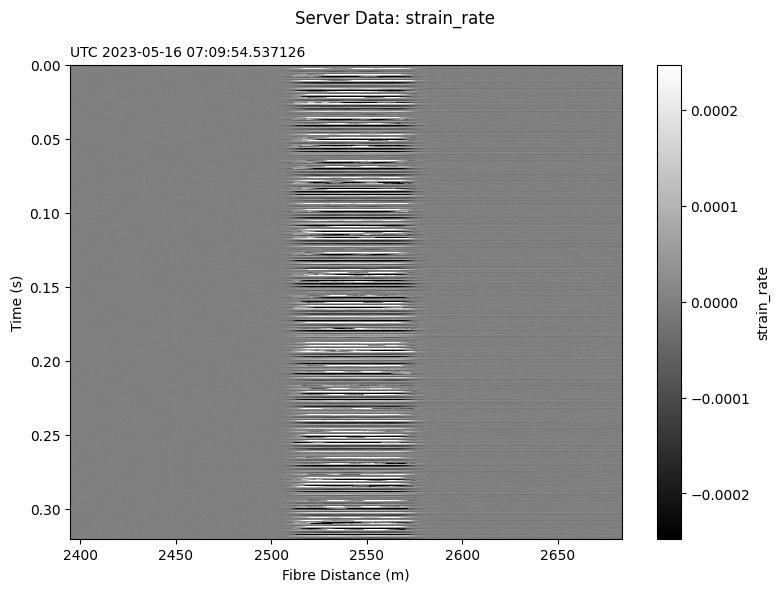

In [13]:
from treble import acq_client

ip="10.0.0.90"
port=48000

client = acq_client.acq_Client()
client.connect_to_server(f"tcp://{ip}:{port}")

# Acquire most recent 2 frames of data, and metadata
data, md = client.fetch_data_product([-1, -2],timeout=20000)
print(f"Acquired {md['data_product']} data from {ip}:{port}")
print(f"Raw Data (n_frames, nt, nx): {data.shape}")
data = data.reshape((data.shape[0] * data.shape[1], -1))
print(f"Reshaped Data (nt, nx): {data.shape}\n")

t = np.arange(0, data.shape[0]) * md['dT'] + md["acq_times"][0]
x = np.arange(0, data.shape[1]) * md['dx'] + md['sensing_range'][0]

for key, val in md.items(): print(f" {key}: {val}")
plot_data(data, t, x, title=f"Server Data: {md['data_product']}", units=md['data_product'])

## Client Functions
Data can also be acquired using custom functions to pre-process data on the Treble. These "client functions" leverage the significant computing power of the Treble to reduce computational load on the client side, and in the case of averaging and cropping, to reduce the volume of data that must be fetched over the network.

The Treble provides some client functions by default. User-defined client functions can also be added to the Treble by copying them into the file `/opt/trebleserver/clientfunctions/functions.py`, and restarting the TrebleServer using the command `treblestop && treblestart`. 

In [14]:
# Example of a default client function in the correct format to be added to functions.py:
#-----------------------------------------------------------------------------------------
dispatcher = {}

def get_slices_by_range_mean(inp, start_index2=None, end_index2=None, extra_md=None):
    # Returns the mean in space of all data between x-channels start_index2 and end_index2.
    return np.mean(inp[:, :, start_index2:end_index2], axis=2)

# Function must be registered in dispatcher to be available to the client.
dispatcher["get_slices_by_range_mean"] = get_slices_by_range_mean
#-----------------------------------------------------------------------------------------

# A list of all currently available client functions can be retrieved using the client:
client_functions = client.list_client_functions()
for fn in client_functions: print(fn)

calc_rms
calc_rms_multiframe
feedthrough
get_slices_by_range
get_slices_by_indices
get_slices_by_range_mean
subtract_mean_along_space_axis
get_slices_by_range_mean_fft
get_slices_by_range_mean_rfft_hanning
get_time_averaged_panel
return_meta_only
get_baseline_corrected_moving_average_rms
convert_velocity_to_strain_rate
convert_velocity_do_rms
convert_velocity_do_range_mean
get_stats
tone_stream
bandpass_do_rms


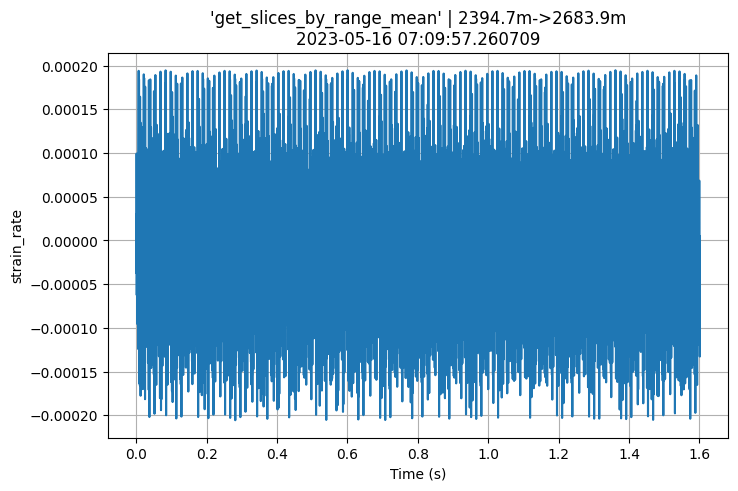

In [15]:
# Client functions are used by passing the function name and arguments to clients.fetch_data_product().
x1 = 100 # channel number
x2 = 200 # channel number
n_frames = 10

data, md = client.fetch_data_product(
        list(range(-n_frames + 1, 1, 1)),
        timeout=20000,
        with_client_fn='get_slices_by_range_mean',
        client_fn_args={
            "start_index2": x1,
            "end_index2": x2,
        }
    )
data = data.reshape((data.shape[0] * data.shape[1], -1))

t = np.arange(0, data.shape[0]) * md['dT']
x = np.arange(0, md['nx']) * md['dx'] + md['sensing_range'][0]
t_start = datetime.utcfromtimestamp(md['acq_times'][0])

plt.figure(figsize=(8, 5))
plt.title(f"'get_slices_by_range_mean' | {x[0]:.1f}m->{x[-1]:.1f}m\n{t_start}")
plt.plot(t, data)
plt.xlabel("Time (s)")
plt.ylabel(md["data_product"])
plt.grid()